# Arize Tutorial: Integrating with UbiOps

Arize and UbiOps are two platforms aimed at different, but connected, parts of the ML pipeline. Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models. UbiOps helps you rapidly deploy and serve your models. In this tutorial we will show how the two can be combined to accelerate model deployment and diagnose issues that emerge in production.

### Steps for this Walkthrough
1. Load in the data and build the model for predicting MPG
2. Integrate Arize into the Deployment
3. Deploy the model onto UbiOps
4. Send in an example model request to UbiOps
5. Analyze data in the Arize platform

# Step 1: Load Data and Build Model

In this tutorial we will be predicting fuel efficiency (MPG) using a Tensorflow model. Here we will load in our data and build out a keras sequential model.

In [ ]:
# Download dependencies and import required libraries
!pip install arize ubiops -q
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import urllib.request

# Load data
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
raw_dataset = pd.read_csv(
    "https://storage.googleapis.com/arize-assets/fixtures/arize-ubiops-tutorial-auto-mpg.csv",
    names=column_names,
    na_values="?",
    comment="\t",
    sep=" ",
    skipinitialspace=True,
)
dataset = raw_dataset.copy()

# Data cleanup
dataset = dataset.dropna()

# Split into train and test set 80-20
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Separate the target value, the "label", from the features. This label (MPG) is the value that you will train the model to predict.
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

# Build the sequential model
model = tf.keras.Sequential(
    [
        # horsepower_normalizer,
        layers.Dense(units=1)
    ]
)

# Configure training procedure
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

# Train the model using the prepared data
history = model.fit(
    train_features,
    train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split=0.2,
)

# Save the model using h5 format for use within our deployment to make predictions
# Note that this will save the model to the folder where our model is
model.save("tensorflow_deployment_package/tensorflow_model.h5")

with (
    urllib.request.urlopen(
        "https://storage.googleapis.com/arize-assets/fixtures/arize-ubiops-tutorial-requirements.txt"
    ) as testfile,
    open("tensorflow_deployment_package/requirements.txt", "w") as f,
):
    f.write(testfile.read().decode())

print("Step 1 ✅: Load Data & Build Model Done!")

Step 1 ✅: Load Data & Build Model Done!


# Step 2: Integrate Arize with the Deployment

Now that we have our model, we can go ahead and create a UbiOps Deployment. First though, let's quickly set up our Arize credentials. You can find your `ARIZE_API_KEY` and `ARIZE_SPACE_KEY` by navigating to the settings page in your workspace (only space admins can see the keys). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.


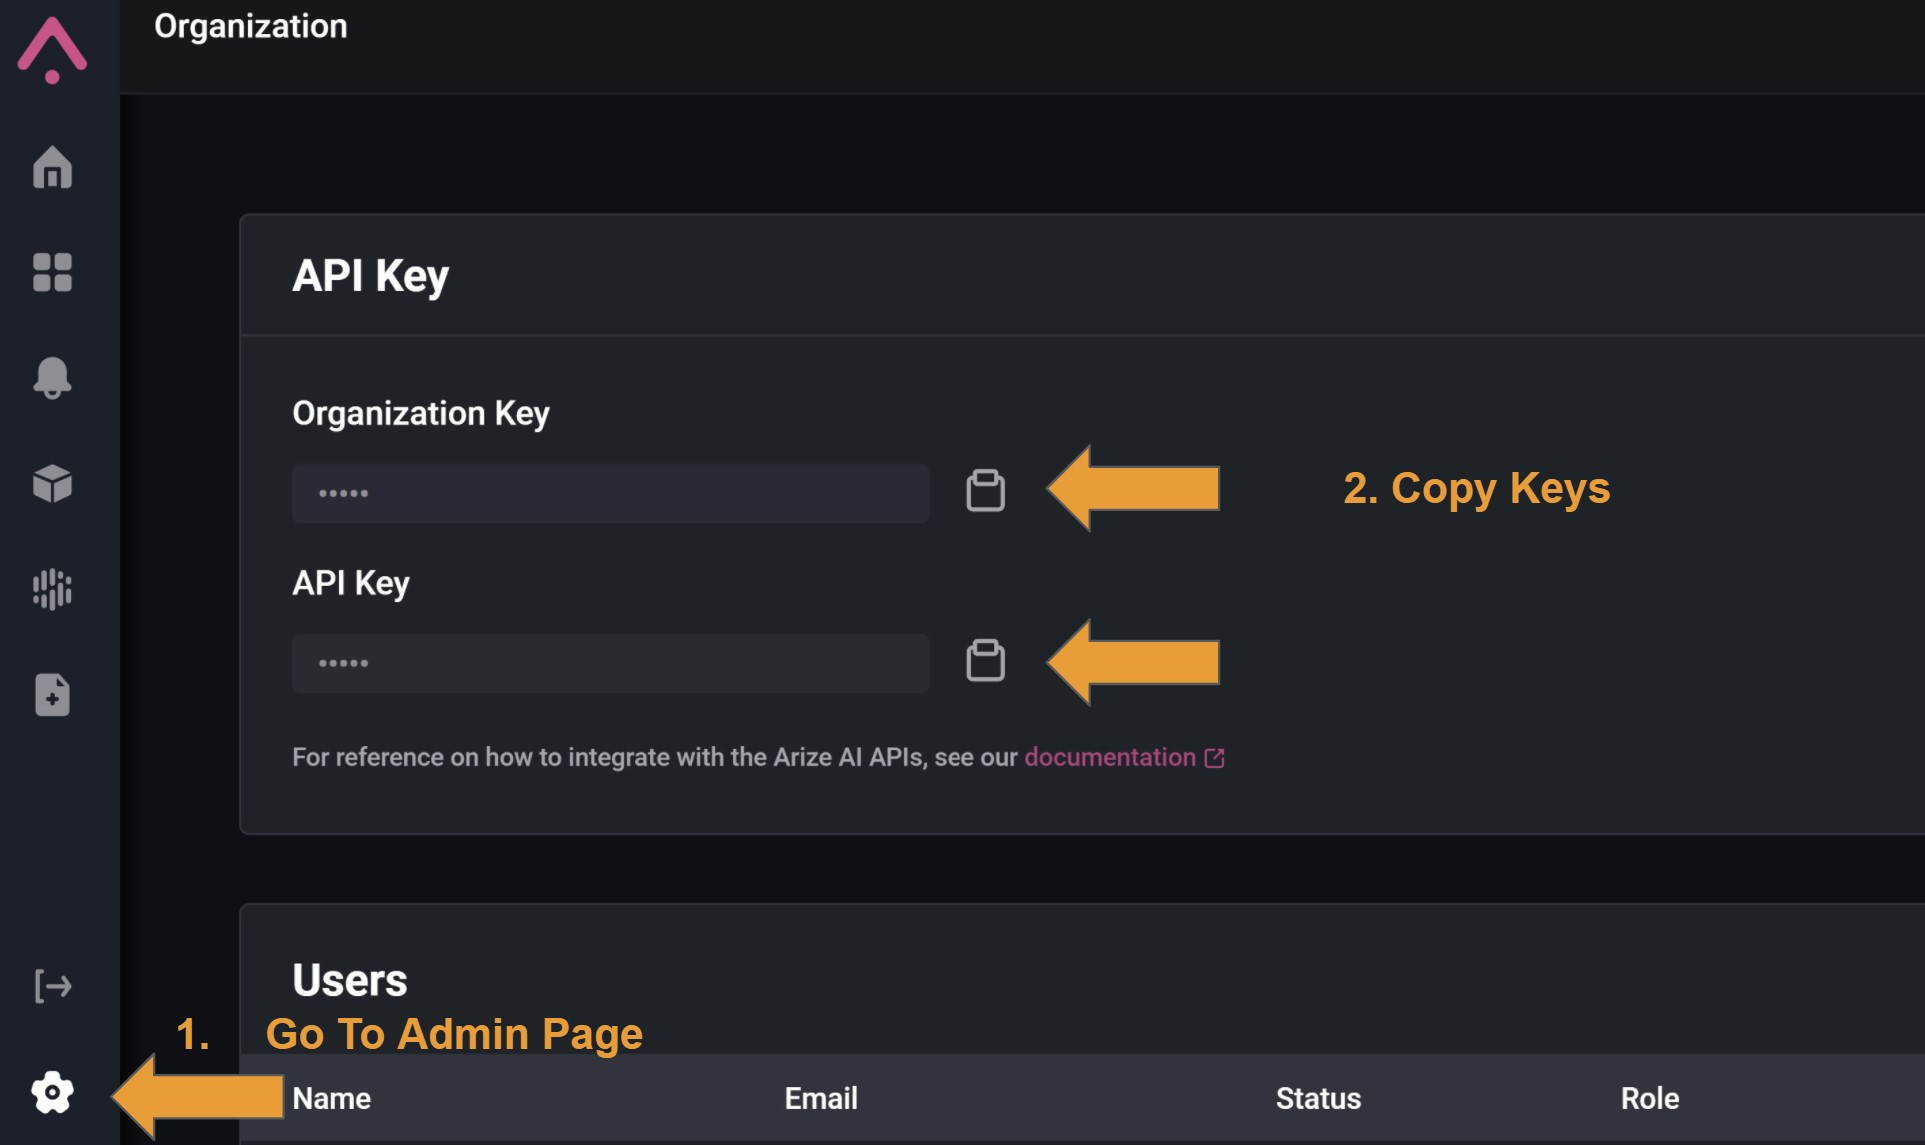

In [ ]:
from arize.api import Client
from arize.utils.types import ModelTypes

ARIZE_SPACE_KEY = "ARIZE_SPACE_KEY"
ARIZE_API_KEY = "ARIZE_API_KEY"

model_id = (
    "arize-ubiops-tutorial"  # This is the model name that will show up in Arize
)
model_version = "v1.0"  # Version of model - can be any string

if ARIZE_SPACE_KEY == "ARIZE_SPACE_KEY" or ARIZE_API_KEY == "ARIZE_API_KEY":
    raise ValueError("❌ NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Arize setup complete!")

✅ Arize setup complete!


Now we're ready to integrate with Arize. To do so, we simply log our data in the `request` function of the deployment. To learn more about UbiOps deployments, visit the [docs](https://ubiops.com/docs/deployments/).

In [ ]:
%%writefile tensorflow_deployment_package/deployment.py
import os
import pandas as pd
from tensorflow.keras.models import load_model
from arize.api import Client
from arize.utils.types import ModelTypes
import datetime
import pandas as pd
import numpy as np

class Deployment:

    def __init__(self, base_directory, context):

        model_file = os.path.join(base_directory, "tensorflow_model.h5")
        self.model = load_model(model_file)

        self.arize = Client(space_key=os.environ.get('ARIZE_SPACE_KEY'), api_key=os.environ.get('ARIZE_API_KEY'))


    def request(self, data):

        input_data = pd.read_csv(data['data'])
        actuals = input_data.pop('MPG')
        prediction = self.model.predict(input_data)

        ########### ARIZE CODE HERE ###########

        ids = pd.DataFrame(input_data.index.values).applymap(str)

        # OPTIONAL: Simulate predictions evenly distributed over 30 days by manually specifying prediction time
        current_time = datetime.datetime.now().timestamp()
        earlier_time = (datetime.datetime.now() - datetime.timedelta(days=30)).timestamp()
        optional_prediction_timestamps = np.linspace(earlier_time, current_time, num=len(ids))
        optional_prediction_timestamps = pd.Series(optional_prediction_timestamps.astype(int))

        responses = self.arize.log(
            model_id="arize-ubiops-tutorial",
            model_type=ModelTypes.NUMERIC,
            model_version="v1",
            prediction_ids= ids,
            prediction_labels=pd.DataFrame(prediction),
            prediction_timestamps=optional_prediction_timestamps,
            actual_labels=actuals,
            features=input_data)
        #######################################


        # Writing the prediction to a csv for further use
        print('Writing prediction to csv')
        pd.DataFrame(prediction).to_csv('prediction.csv', header = ['MPG'], index_label= 'index')

        return {
            "prediction": 'prediction.csv',
        }
print("✅ Deployment created!")

Overwriting tensorflow_deployment_package/deployment.py


# Step 3: Deploy the Model with UbiOps


With our Deployment file created, we can deploy the model to UbiOps. First, let's setup our UbiOps credentials.

[Login](https://app.ubiops.com/) to your UbiOps account and create an API token with project editor admin rights. To do so, click on Users & permissions in the navigation panel, and then click on API tokens. Click on *Add Token* to create a new token.

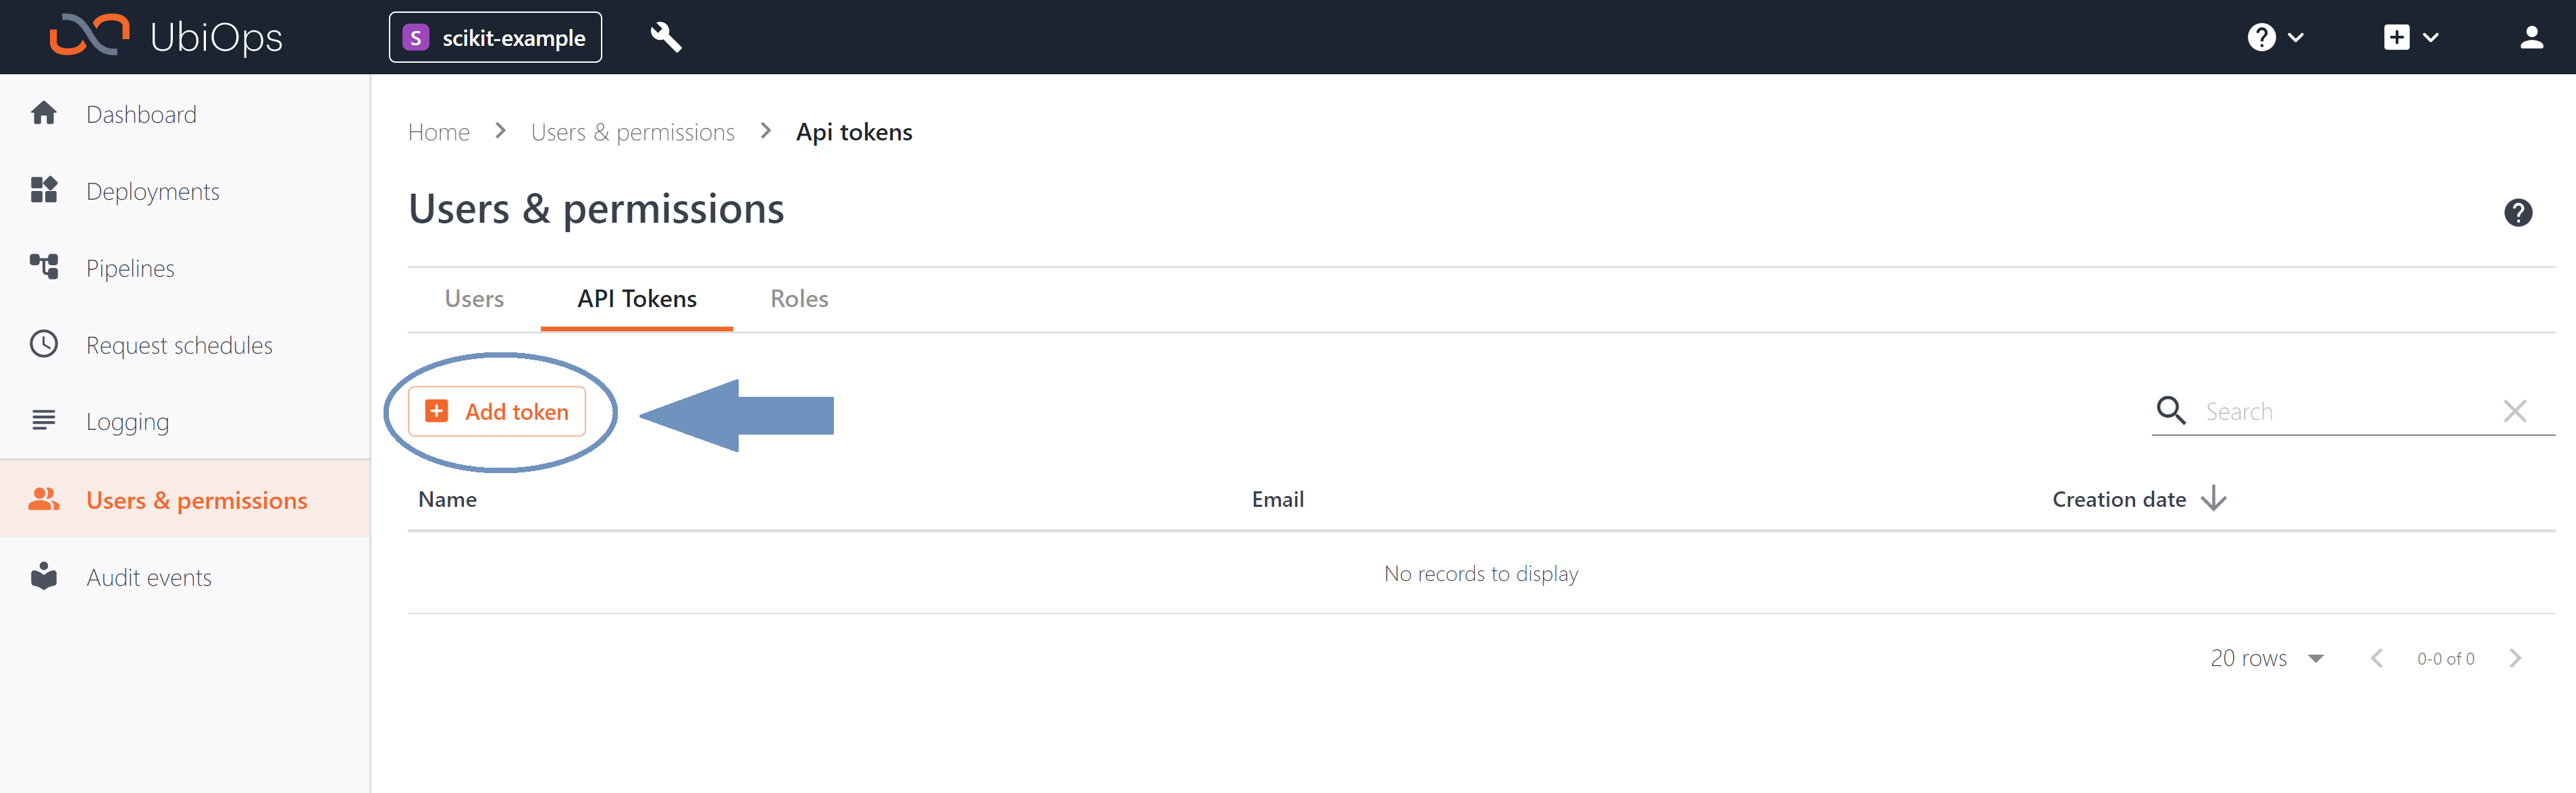

Now fill out the following credentials, replacing `UBIOPS_API_TOKEN` and `UBIOPS_PROJECT_NAME` with your values.

In [ ]:
# Import all necessary libraries
import shutil
import os
import ubiops

UBIOPS_API_TOKEN = (
    "UBIOPS_TOKEN"  # Make sure this is in the format "Token token-code"
)
UBIOPS_PROJECT_NAME = "UBIOPS_PROJECT_NAME"


UBIOPS_DEPLOYMENT_NAME = "tensorflow-deployment-1"
UBIOPS_DEPLOYMENT_VERSION = "v1"

client = ubiops.ApiClient(
    ubiops.Configuration(
        api_key={"Authorization": UBIOPS_API_TOKEN},
        host="https://api.ubiops.com/v2.1",
    )
)
api = ubiops.CoreApi(client)
print("✅ UbiOps client initalized!")

✅ UbiOps client initalized!


Now we're ready to deploy to UbiOps!

In [ ]:
# Create the UbiOps deployment
deployment_template = ubiops.DeploymentCreate(
    name=UBIOPS_DEPLOYMENT_NAME,
    description="Tensorflow deployment",
    input_type="structured",
    output_type="structured",
    input_fields=[
        ubiops.DeploymentInputFieldCreate(
            name="data",
            data_type="blob",
        ),
    ],
    output_fields=[
        ubiops.DeploymentOutputFieldCreate(name="prediction", data_type="blob"),
    ],
    labels={"demo": "tensorflow"},
)

api.deployments_create(
    project_name=UBIOPS_PROJECT_NAME, data=deployment_template
)

api.deployment_environment_variables_create(
    project_name=UBIOPS_PROJECT_NAME,
    deployment_name=UBIOPS_DEPLOYMENT_NAME,
    data=ubiops.EnvironmentVariableCreate(
        name="ARIZE_SPACE_KEY", value=ARIZE_SPACE_KEY, secret=True
    ),
)

api.deployment_environment_variables_create(
    project_name=UBIOPS_PROJECT_NAME,
    deployment_name=UBIOPS_DEPLOYMENT_NAME,
    data=ubiops.EnvironmentVariableCreate(
        name="ARIZE_API_KEY", value=ARIZE_API_KEY, secret=True
    ),
)

# Create the version
version_template = ubiops.DeploymentVersionCreate(
    version=UBIOPS_DEPLOYMENT_VERSION,
    language="python3.8",
    memory_allocation=512,
    minimum_instances=0,
    maximum_instances=1,
    maximum_idle_time=1800,  # = 30 minutes
)

api.deployment_versions_create(
    project_name=UBIOPS_PROJECT_NAME,
    deployment_name=UBIOPS_DEPLOYMENT_NAME,
    data=version_template,
)

# Zip the deployment package
shutil.make_archive(
    "tensorflow_deployment_package", "zip", ".", "tensorflow_deployment_package"
)

# Upload the zipped deployment package
file_upload_result = api.revisions_file_upload(
    project_name=UBIOPS_PROJECT_NAME,
    deployment_name=UBIOPS_DEPLOYMENT_NAME,
    version=UBIOPS_DEPLOYMENT_VERSION,
    file="tensorflow_deployment_package.zip",
)
print("✅ Model delpoyed to UbiOps!")

✅ Model delpoyed to UbiOps!


# Step 4: Send in Request to UbiOps

Now that our model is deployed, we are able to send in requests to make predictions. We will download and use `dummy_data.csv` which contains feature data that will be used by the model to make predictions.

In [ ]:
# download dummy_data.csv locally
with (
    urllib.request.urlopen(
        "https://storage.googleapis.com/arize-assets/fixtures/arize-ubiops-tutorial-dummy-data-to-predict.csv"
    ) as testfile,
    open("dummy_data.csv", "w") as f,
):
    f.write(testfile.read().decode())

Go ahead and download this file locally after it downloads to your temporary colab storage.

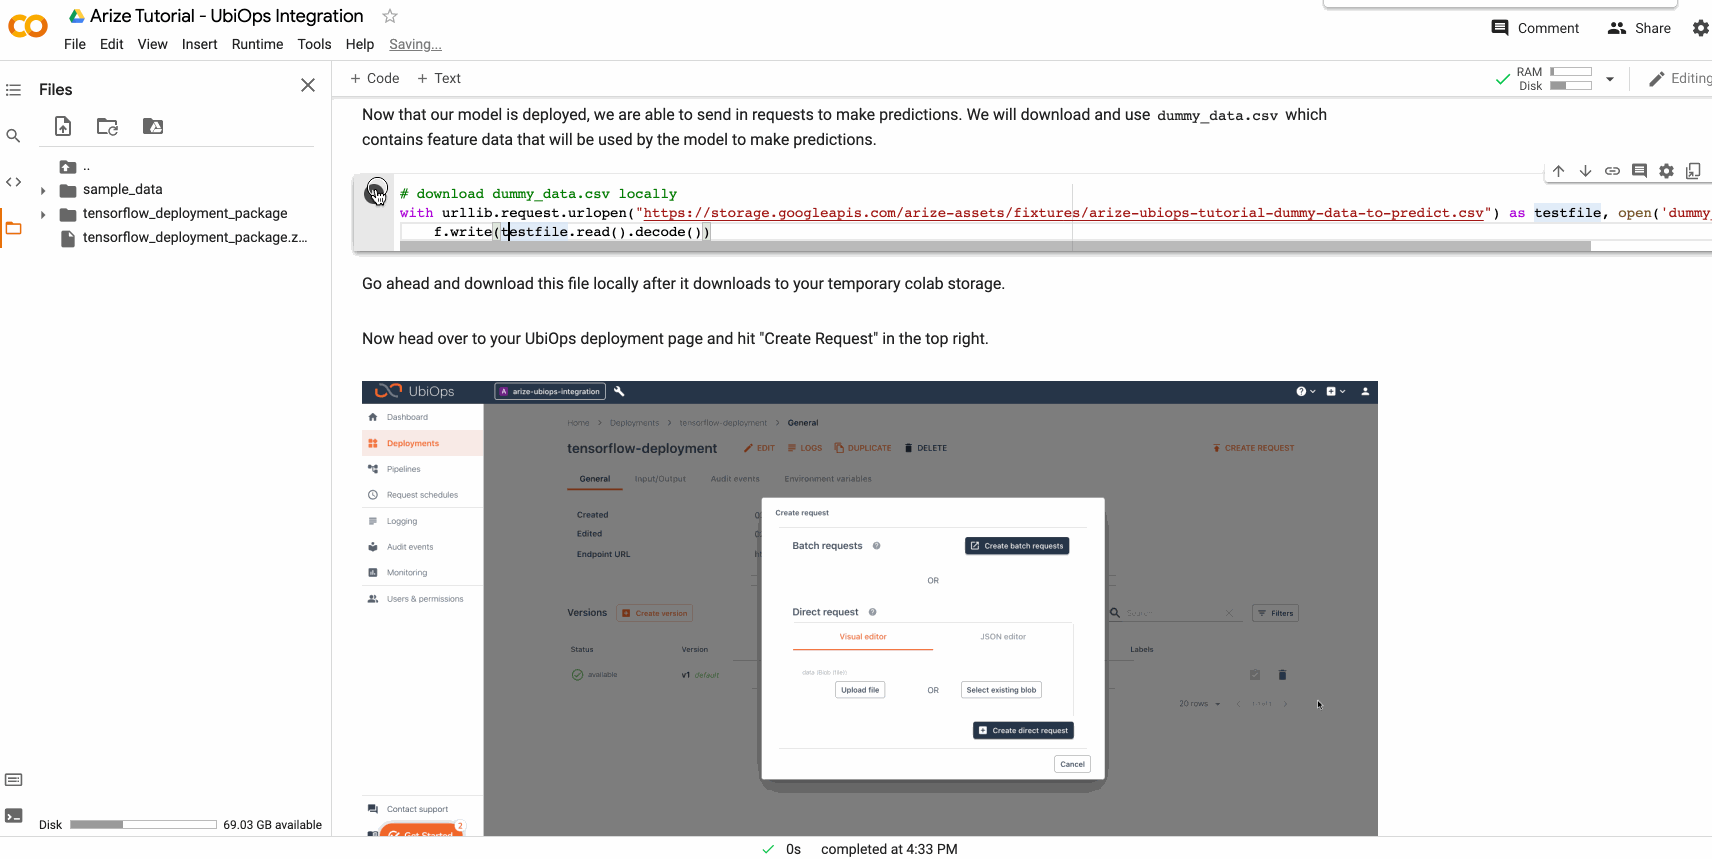

Now head over to your UbiOps deployment page and hit "Create Request" in the top right.

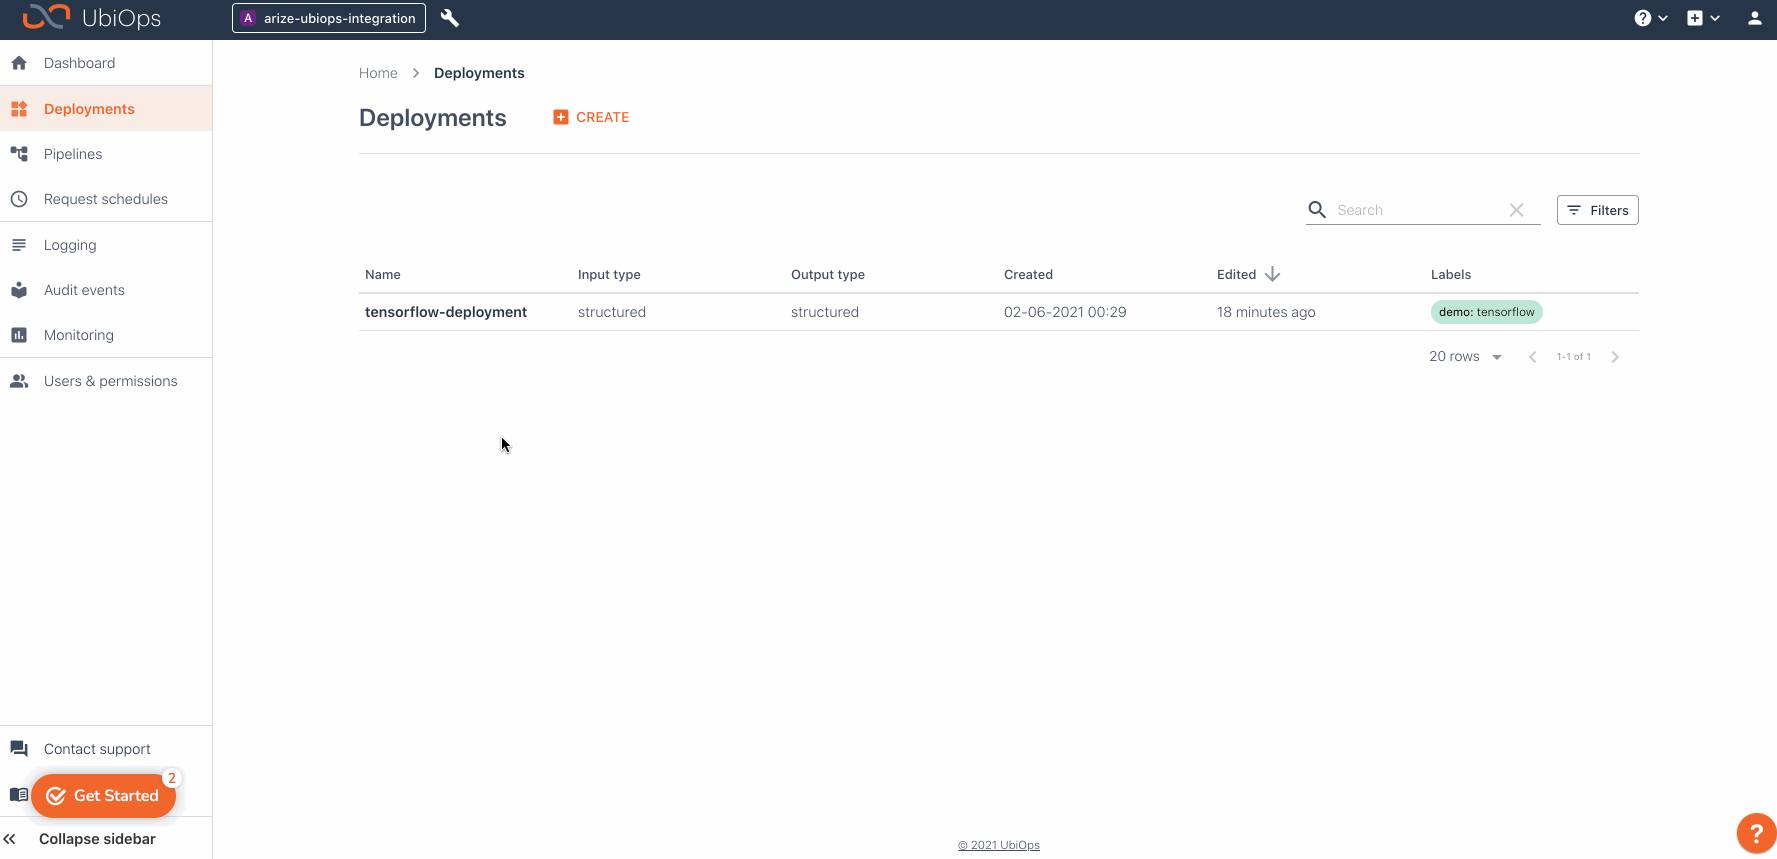

Go ahead and hit "Upload File" and use the `dummy_data.csv` we downloaded in the previous step. When that is done, you should get a screen like this:

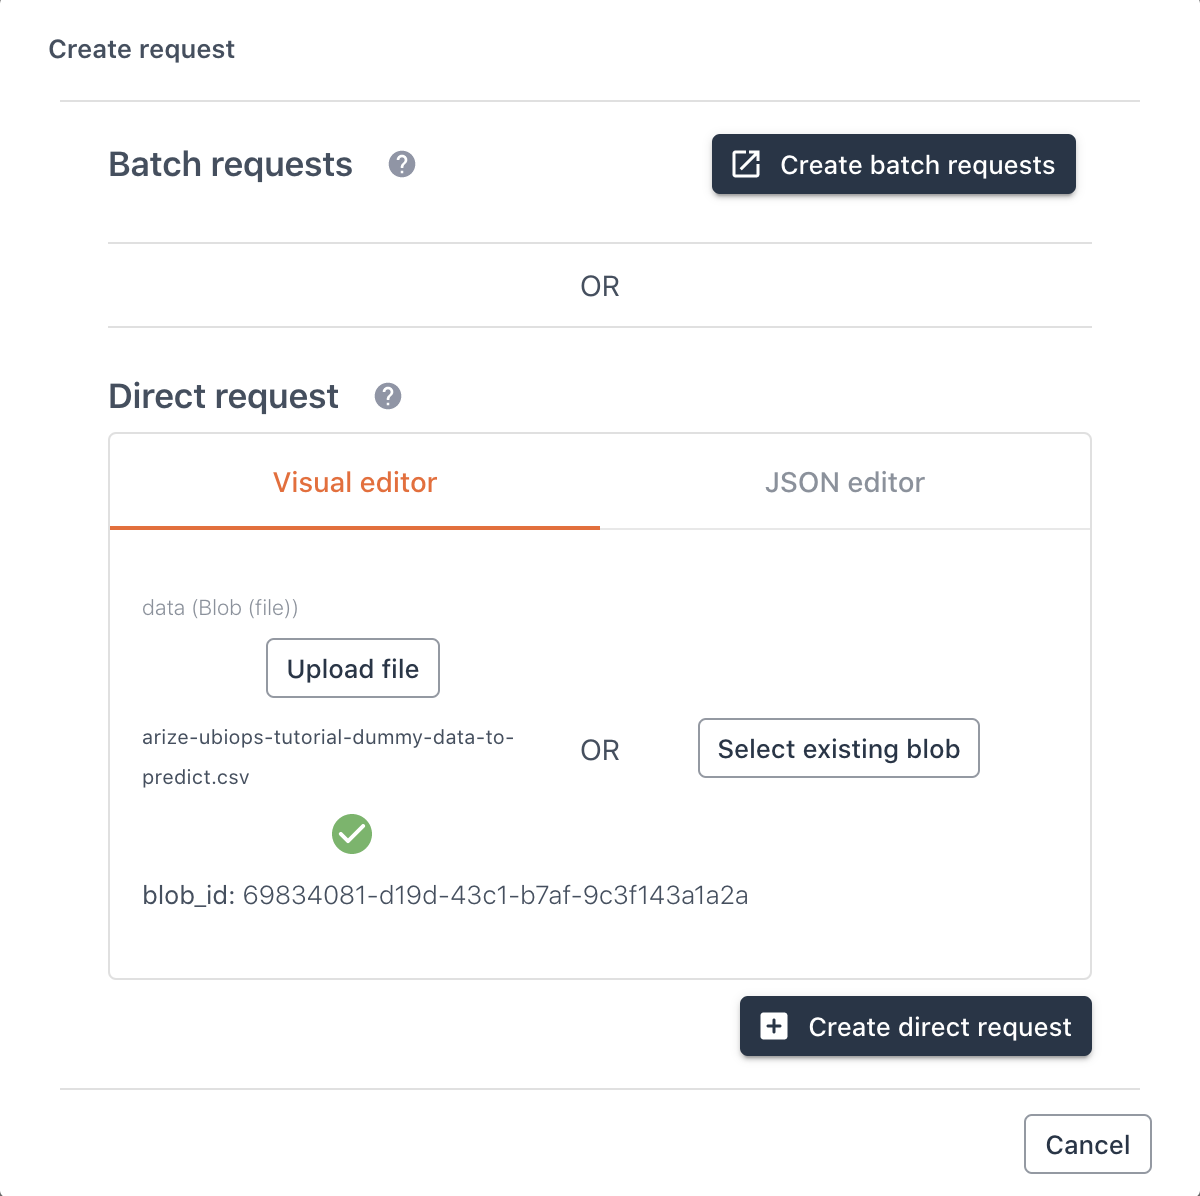

Congratulations! You now have created, deployed, and made requests to a model with the UbiOps platform. Now that our model has some data, we can head over to Arize to monitor and observe it.

# Step 5: Analyze Data in the Arize Platform

Head over to the [Arize platform](https://app.arize.com/) and locate the `arize-ubiops-tutorial` model we have created. For some useful information and visualizations follow this gif below to create a performance dashboard.

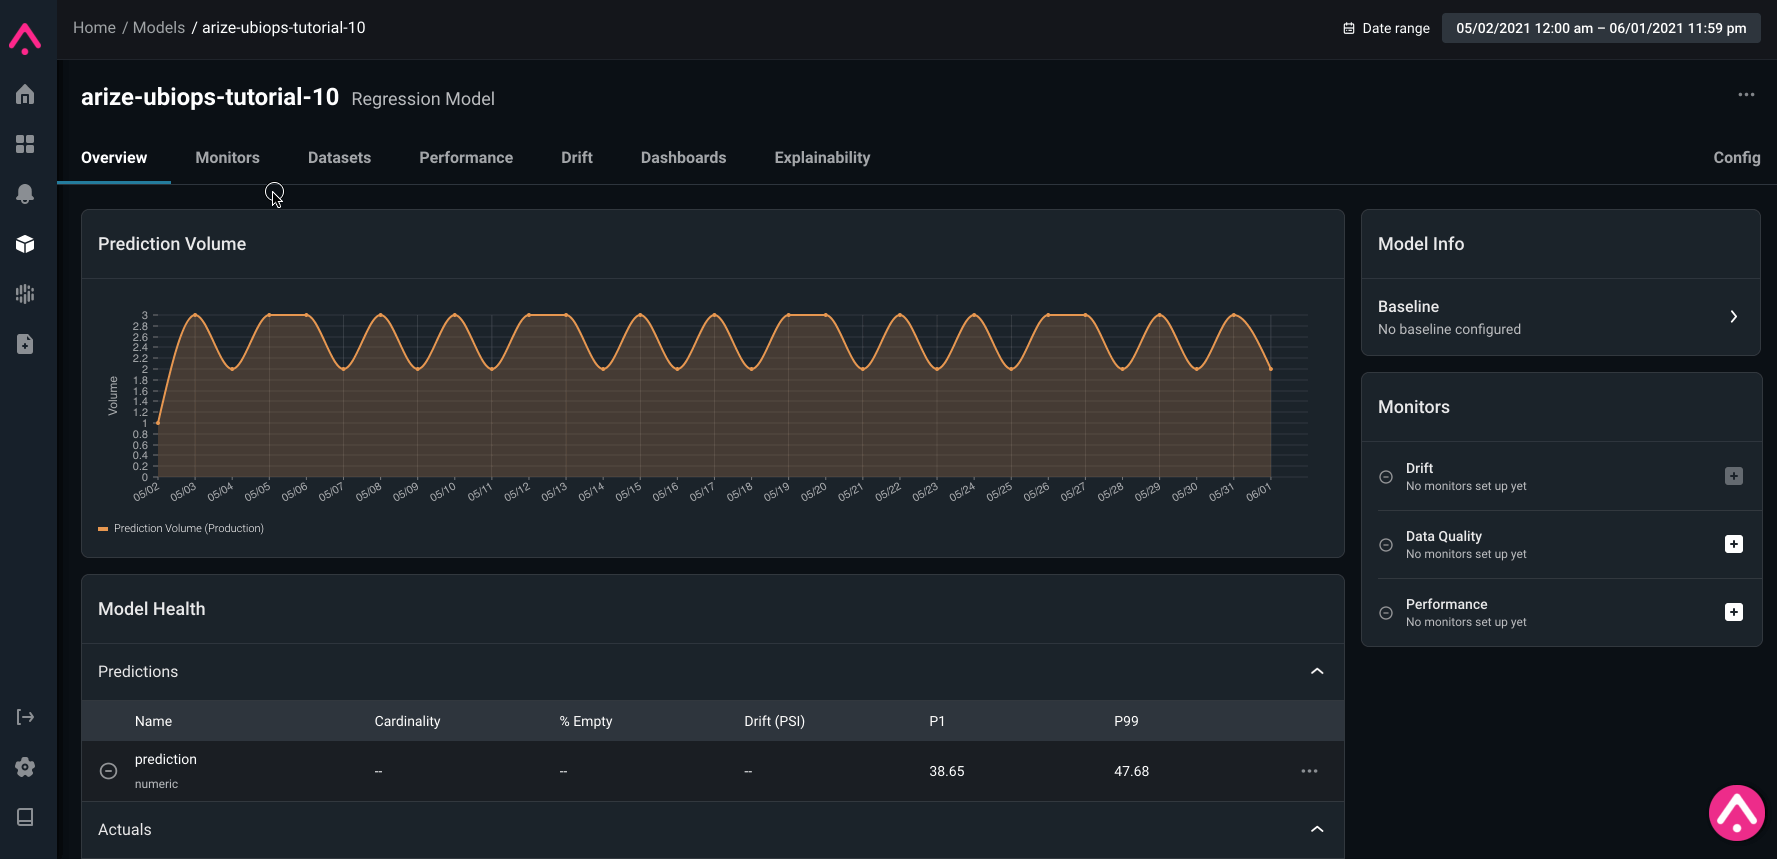

Arize allows you to quickly dive into your model's performance. Feel free to look around the platform and explore all it has to offer. For more examples of what it can do, visit the [docs](https://arize.gitbook.io/arize/).

### Overview
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
